In [1]:
#Import dependencies

import os
import pandas as pd
import csv
import numpy as np
import sklearn
import seaborn as sns
color = sns.color_palette()

import matplotlib.pyplot as plt


In [2]:
#Importing Properties 2016 from zillow
csv_file1 = "zillow_ML/properties_2017.csv"
houses2017_df = pd.read_csv(csv_file1)

# Import log error
csv_file2 = "zillow_ML/train_2017.csv"
train2017_df = pd.read_csv(csv_file2, parse_dates=["transactiondate"])


C:\Users\rsdut\.conda\envs\Pythondata\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


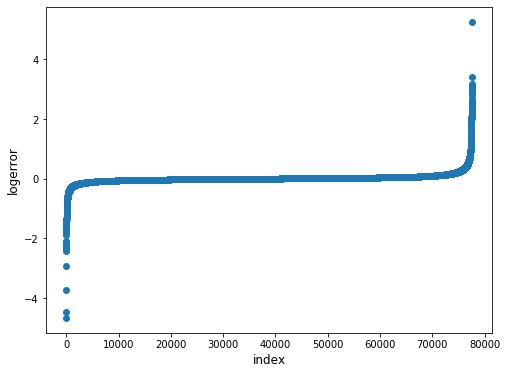

In [3]:
# Let's plot the logerror to see if there are extreme observations
plt.figure(figsize=(8,6))
plt.scatter(range(train2017_df.shape[0]), np.sort(train2017_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

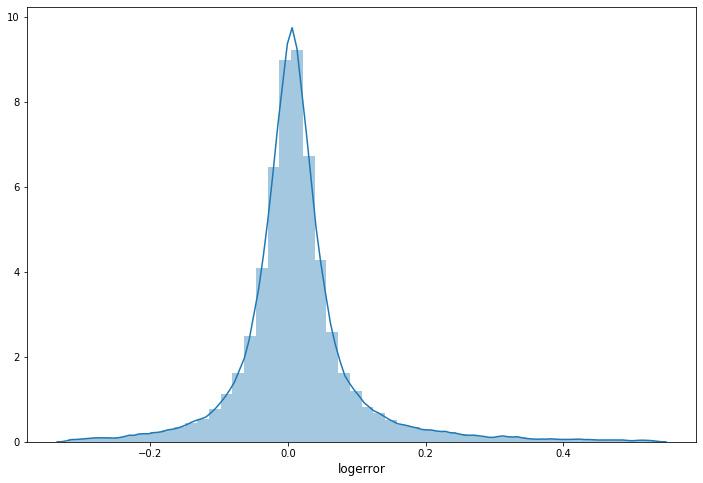

In [4]:
# Let's remove the very extreme observations to have a more sensible analysis
# Delete obs above 99 percentile and below 1 percentile
ulim = np.percentile(train2017_df.logerror.values, 99)
llim = np.percentile(train2017_df.logerror.values, 1)

train2017_df = train2017_df[train2017_df["logerror"]< ulim]
train2017_df = train2017_df[train2017_df["logerror"]> llim]

plt.figure(figsize=(12,8))
sns.distplot(train2017_df.logerror.values)
plt.xlabel('logerror', fontsize=12)
plt.show()

In [5]:
# Select subset of data that we will use
df = houses2017_df[['parcelid','bathroomcnt', 'bedroomcnt', 'lotsizesquarefeet',
                  'yearbuilt', 'calculatedfinishedsquarefeet', 'regionidcounty', 'taxvaluedollarcnt']]

In [6]:
# Merge the datasets
df_merged = pd.merge(train2017_df, df, on='parcelid', how='left')
print(df_merged.shape)


(76059, 10)


In [7]:
# Check number of missing values for each variable
missing_df = df_merged.isnull().sum(axis=0).reset_index()
missing_df

,index,0
0,parcelid,0
1,logerror,0
2,transactiondate,0
3,bathroomcnt,28
4,bedroomcnt,28
5,lotsizesquarefeet,8165
6,yearbuilt,269
7,calculatedfinishedsquarefeet,204
8,regionidcounty,28
9,taxvaluedollarcnt,29


In [8]:
# Drop row with missing values to continue analysis
df_noNA = df_merged.dropna()
df_noNA.shape

(67720, 10)

In [9]:
# Assign X (data) and y (target)
# Select covariates X
X = df_noNA[['bedroomcnt','bathroomcnt', 'lotsizesquarefeet',
             'yearbuilt', 'calculatedfinishedsquarefeet', 'regionidcounty', 'taxvaluedollarcnt']]
# Select outcome y
y = df_noNA["logerror"].values.reshape(-1, 1)

# get dummy for regioidcounty
X = pd.get_dummies(X, columns = ['regionidcounty'])
# Print dimensions
print(X.shape, y.shape)
X
X.head()

(67720, 9) (67720, 1)


,bedroomcnt,bathroomcnt,lotsizesquarefeet,yearbuilt,calculatedfinishedsquarefeet,taxvaluedollarcnt,regionidcounty_1286.0,regionidcounty_2061.0,regionidcounty_3101.0
0,4.0,3.5,4506.0,1998.0,3100.0,1023282.0,1,0,0
1,2.0,1.0,12647.0,1967.0,1465.0,464000.0,0,1,0
2,3.0,2.0,8432.0,1962.0,1243.0,564778.0,1,0,0
3,4.0,3.0,13038.0,1970.0,2376.0,145143.0,0,0,1
4,3.0,3.0,278581.0,1964.0,1312.0,119407.0,0,0,1


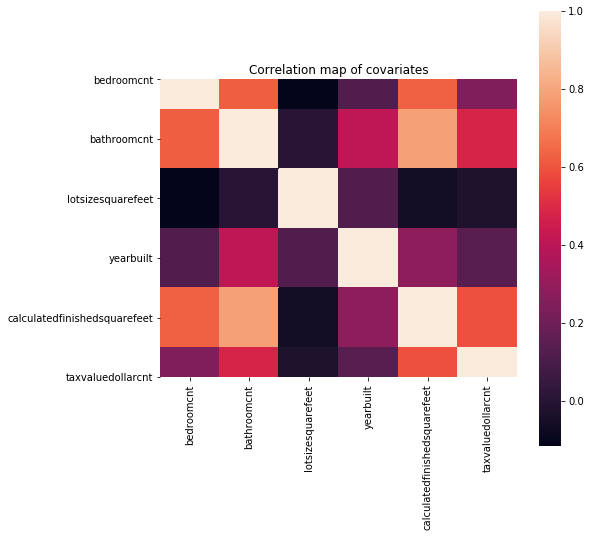

In [10]:
# get correlation
Xcorr = X[['bedroomcnt','bathroomcnt', 'lotsizesquarefeet',
                  'yearbuilt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
corrmat = Xcorr.corr()
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1.,square=True)
plt.title("Correlation map of covariates", fontsize=12)
plt.show()

In [11]:
# Split the data into training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [12]:
# Transform data to use in linear regression and other types of regressions
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

# Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)



In [13]:
# Create a LinearRegression model and fit it to the scaled training data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

Weight coefficients:  [[-1.10000768e-02  1.13186135e-02  4.40469540e-03 -1.55818449e-02
   7.32614457e-02 -1.87415730e-02  1.04904722e+12  6.84679819e+11
   1.16412325e+12]]
y-axis intercept:  [-0.00010746]


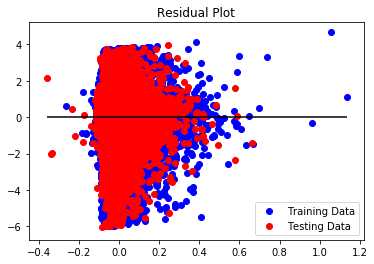

In [15]:
# Make predictions using a fitted model
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled),
            model.predict(X_train_scaled) - y_train_scaled, c="blue",
            label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled,
            c="red", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=model.predict(X_test_scaled).min(), xmax=model.predict(X_train_scaled).max())
plt.title("Residual Plot")
plt.show()



In [16]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)


print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.9946619032986398, R2: 0.002779842649321962
